
# **Predikcija  guzve u metrou na osnovu vremeskih prilika**
### *Projekat iz nadgledanog ucenja*

## Biblioteke

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
import seaborn as sns
import pydotplus
import math
from xgboost import XGBRegressor
from scipy.stats.mstats import winsorize
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

##Ucitavanje

In [ ]:
url = 'https://raw.githubusercontent.com/aleksicmilica/ml-projekat1/main/dataset.csv'
dataset = pd.read_csv(url)

In [ ]:
dataset.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

In [ ]:
dataset.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

## Predobrada

###Provera prisustva missing values

In [ ]:
total_missing = dataset.isnull().sum()
print(total_missing)
if (total_missing == 0).all():
  print("Sve vrednosti su prisutne u dataset-u")

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64
Sve vrednosti su prisutne u dataset-u


Za svaku kolone je vrsena provera da li postoje missing values, i utvrdjeno je da ni u jednoj koloni ne postoje.

###Provera da li su svi podaci odgovarajuceg tipa

In [ ]:
irregular_values = ((dataset.clouds_all < 0) | (dataset.clouds_all > 100)).sum() + (dataset.rain_1h < 0).sum()  + (dataset.snow_1h < 0).sum() + (dataset.traffic_volume < 0).sum()
print(irregular_values)

0


In [ ]:
numerical_type = pd.api.types.is_numeric_dtype(dataset["temp"].dtype) and pd.api.types.is_numeric_dtype(dataset["traffic_volume"].dtype)
print(numerical_type)

True


In [ ]:
string_type = dataset['holiday'].apply(lambda x: x.replace(" ", "").isalpha() or x.isspace()).all() and dataset['weather_main'].apply(lambda x: x.replace(" ", "").isalpha() or x.isspace()).all() and dataset['weather_description'].apply(lambda x: x.replace(" ", "").isalpha() or x.isspace()).all()
print(string_type)

True


In [ ]:
if irregular_values == 0 and numerical_type and string_type:
  print("Svi podaci su odgovarajuceg tipa")

Svi podaci su odgovarajuceg tipa


Izvrsena je provera da li su podaci u kolonama odgovarajuceg tipa i za numericke atribute poput **rain_1h**, **snow_1h**, **traffic_volume**, da li su nenegativni i za atribut **clouds_all**, kako predstavlja procente, da li je u opsegu [0,100].

### Detekcija i otklanjanje outlier-a, normalizacija podataka

Prvi atribut koji se obradjuje je temperatura

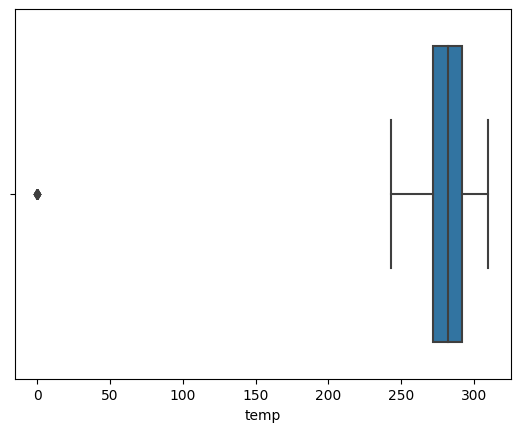

In [ ]:
sns.boxplot(x = dataset['temp'])
plt.show()

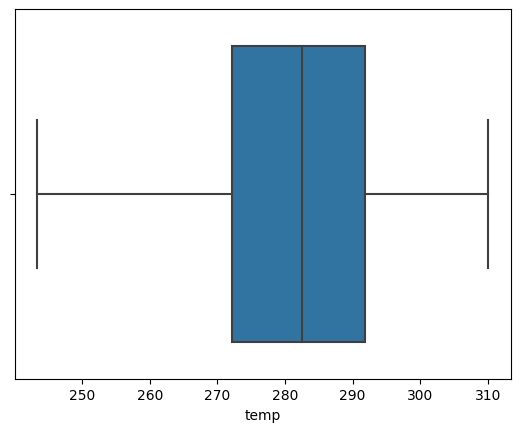

In [ ]:
Q1 = dataset['temp'].quantile(0.25)
Q3 = dataset['temp'].quantile(0.75)
IQR = Q3 - Q1
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR
outliers_15_low = (dataset['temp']<lower_lim)
outliers_15_up = (dataset['temp']> upper_lim)
dataset = dataset[~(outliers_15_low | outliers_15_up)]
sns.boxplot(x = dataset['temp'])
plt.show()

Primenom IQR  moze se primetiti prisustvu outlier-a koji se otklanjaju, nakon cega grafikon raspodele ima bolju formu

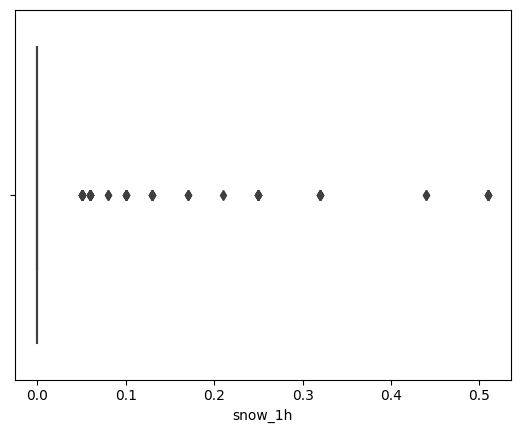

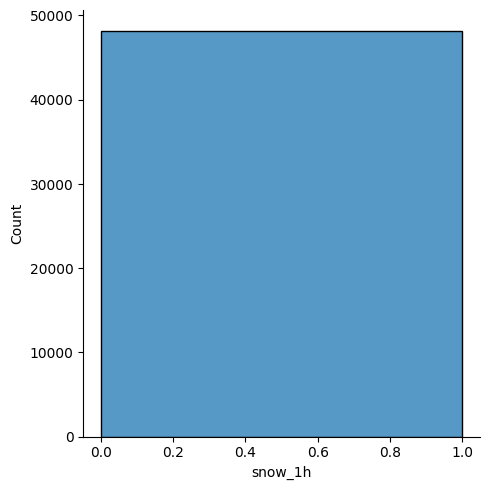

In [ ]:
sns.boxplot(x = dataset['snow_1h'])
sns.displot(dataset, x = dataset['snow_1h'],binwidth=1)
plt.show()

Naredni atribut koji se obradjuje je **snow_1h**, za koji se dobija da se sve vrednosti krecu u opsegu od 0 do 1, pa nije izvrsena pretraga outliera, jer vrednost 0 znacajno vise zastupljena u odnosu na ostale, pa bi sve ostale vrednosti proglasile za outlier-e, nakon cega bi bilo moguce izbaciti atribut, a atribut logicki smatrano ima udela na izlaznu vrednost, pa se ne vrsi izbacivanje outliera

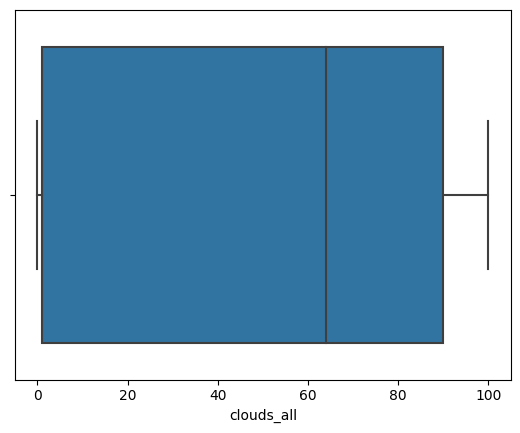

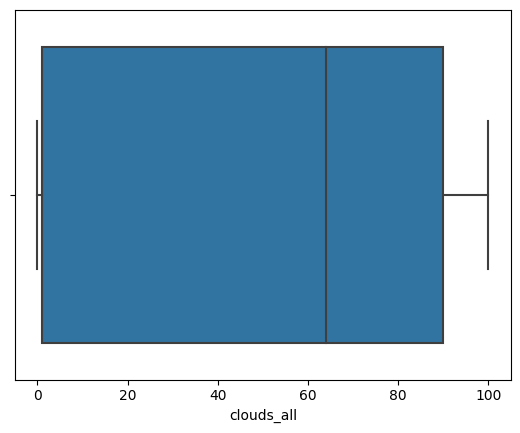

In [ ]:
sns.boxplot(x = dataset['clouds_all'])
plt.show()
Q1 = dataset['clouds_all'].quantile(0.25)
Q3 = dataset['clouds_all'].quantile(0.75)
IQR = Q3 - Q1
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR
outliers_15_low = (dataset['clouds_all']<lower_lim)
outliers_15_up = (dataset['clouds_all']> upper_lim)
dataset = dataset[~(outliers_15_low | outliers_15_up)]
sns.boxplot(x = dataset['clouds_all'])
plt.show()

Nakon plotovanja distribucije atributa **clouds_all** vizuelno se moze utvrditi da ne postoje outlier-i, ali je ipak primenjen IQR algoritam za otklanjanje radi sigurnosti.


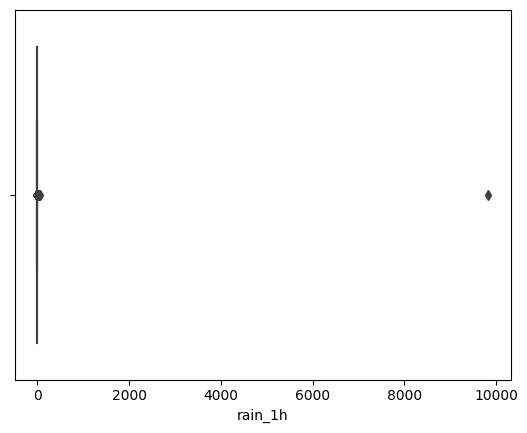

In [ ]:
sns.boxplot(x = dataset['rain_1h'])
plt.show()

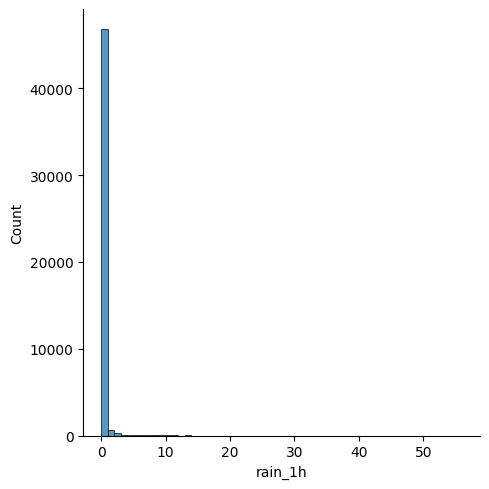

In [ ]:
dataset = dataset[dataset['rain_1h']<2000]
sns.displot(dataset, x = dataset['rain_1h'],binwidth=1)
plt.show()

Za atribut **rain_1h** nakon plotovanja distribucije, utvrdjuje se postojanje jedno vrednosti, znatno vece od ostalih, te se ona proglasa za outliera i izbacuje iz dataseta.

In [ ]:
for index,i in  enumerate(['temp', 'rain_1h', 'snow_1h', 'clouds_all']):

  min_vr = dataset[i].min()
  dataset[i] = dataset[i] - min_vr
  max_vr = dataset[i].max()
  dataset[i] = dataset[i] / max_vr
dataset

holiday      temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        None  0.673215      0.0      0.0        0.40        Clouds   
1        None  0.689412      0.0      0.0        0.75        Clouds   
2        None  0.692711      0.0      0.0        0.90        Clouds   
3        None  0.700960      0.0      0.0        0.90        Clouds   
4        None  0.716107      0.0      0.0        0.75        Clouds   
...       ...       ...      ...      ...         ...           ...   
48199    None  0.600780      0.0      0.0        0.75        Clouds   
48200    None  0.590432      0.0      0.0        0.90        Clouds   
48201    None  0.589982      0.0      0.0        0.90  Thunderstorm   
48202    None  0.580384      0.0      0.0        0.90        Clouds   
48203    None  0.580834      0.0      0.0        0.90        Clouds   

          weather_description            date_time  traffic_volume  
0            scattered clouds  2012-10-02 09:00:00            5545  
1               broken clouds  2012-10-02 10:00:00            4516  
2             overcast clouds  2012-10-02 11:00:00            4767  
3             overcast clouds  2012-10-02 12:00:00            5026  
4               broken clouds  2012-10-02 13:00:00            4918  
...                       ...                  ...             ...  
48199           broken clouds  2018-09-30 19:00:00            3543  
48200         overcast clouds  2018-09-30 20:00:00            2781  
48201  proximity thunderstorm  2018-09-30 21:00:00            2159  
48202         overcast clouds  2018-09-30 22:00:00            1450  
48203         overcast clouds  2018-09-30 23:00:00             954  

[48193 rows x 9 columns]

Izvrsena je normalizacija numerckih atributa na opseg [0,1]

###Kodiranje katerogickih vrednosti

In [ ]:
dataset['weather_description'] = dataset['weather_description'].str.lower()
dataset['weather_main'] = dataset['weather_main'].str.lower()
dataset['holiday'] = dataset['holiday'].str.lower()

In [ ]:
dataset['weather_main'].value_counts()

clouds          15164
clear           13381
mist             5950
rain             5671
snow             2876
drizzle          1821
haze             1360
thunderstorm     1034
fog               912
smoke              20
squall              4
Name: weather_main, dtype: int64

In [ ]:
dataset[dataset['weather_main'] == 'snow']['weather_description'].value_counts()

light snow             1946
heavy snow              616
snow                    293
light shower snow        11
light rain and snow       6
sleet                     3
shower snow               1
Name: weather_description, dtype: int64

In [ ]:
dataset[dataset['weather_main'] == 'rain']['weather_description'].value_counts()

light rain                     3372
moderate rain                  1664
heavy intensity rain            467
proximity shower rain           136
very heavy rain                  17
light intensity shower rain      13
freezing rain                     2
Name: weather_description, dtype: int64

In [ ]:
dataset[dataset['weather_main'] == 'fog']['weather_description'].value_counts()

fog    912
Name: weather_description, dtype: int64

Ideja je da se atributi **weather_main** i **weather_description** kodiraju jednom decimalnom vrednoscu, tako da se izmedju 0 i 1 nalaze sve vrednosti **weather_description** koje se nalaze uz jednu vrednost atributa **weather_main**-a, pa od 1 do 2 sve vrednosti **weather_description** koje se nalaze uz drugu vrednost atributa **weather_main**-a itd.    

In [ ]:
r_dict = {}
for index,i in  enumerate(dataset['weather_main'].unique()):
  deo = dataset[dataset['weather_main']==i]['weather_description'].unique()
  br = len(deo)
  r_dict[i]={}
  for index2, i2 in enumerate(deo):
    r_dict[i][i2] = index+index2/br
r_dict

{'clouds': {'scattered clouds': 0.0,
  'broken clouds': 0.25,
  'overcast clouds': 0.5,
  'few clouds': 0.75},
 'clear': {'sky is clear': 1.0},
 'rain': {'light rain': 2.0,
  'proximity shower rain': 2.142857142857143,
  'moderate rain': 2.2857142857142856,
  'heavy intensity rain': 2.4285714285714284,
  'freezing rain': 2.571428571428571,
  'light intensity shower rain': 2.7142857142857144,
  'very heavy rain': 2.857142857142857},
 'drizzle': {'light intensity drizzle': 3.0,
  'drizzle': 3.25,
  'heavy intensity drizzle': 3.5,
  'shower drizzle': 3.75},
 'mist': {'mist': 4.0},
 'haze': {'haze': 5.0},
 'fog': {'fog': 6.0},
 'thunderstorm': {'proximity thunderstorm': 7.0,
  'thunderstorm with light rain': 7.111111111111111,
  'proximity thunderstorm with rain': 7.222222222222222,
  'thunderstorm with heavy rain': 7.333333333333333,
  'thunderstorm with rain': 7.444444444444445,
  'proximity thunderstorm with drizzle': 7.555555555555555,
  'thunderstorm': 7.666666666666667,
  'thundersto

In [ ]:
for i in  dataset.index:
  dataset['weather'] = 0
for i in  dataset.index:
  dataset['weather'][i] = r_dict[dataset['weather_main'][i]][dataset['weather_description'][i]]


In [ ]:
dataset

holiday      temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        none  0.673215      0.0      0.0        0.40        clouds   
1        none  0.689412      0.0      0.0        0.75        clouds   
2        none  0.692711      0.0      0.0        0.90        clouds   
3        none  0.700960      0.0      0.0        0.90        clouds   
4        none  0.716107      0.0      0.0        0.75        clouds   
...       ...       ...      ...      ...         ...           ...   
48199    none  0.600780      0.0      0.0        0.75        clouds   
48200    none  0.590432      0.0      0.0        0.90        clouds   
48201    none  0.589982      0.0      0.0        0.90  thunderstorm   
48202    none  0.580384      0.0      0.0        0.90        clouds   
48203    none  0.580834      0.0      0.0        0.90        clouds   

          weather_description            date_time  traffic_volume  weather  
0            scattered clouds  2012-10-02 09:00:00            5545     0.00  
1               broken clouds  2012-10-02 10:00:00            4516     0.25  
2             overcast clouds  2012-10-02 11:00:00            4767     0.50  
3             overcast clouds  2012-10-02 12:00:00            5026     0.50  
4               broken clouds  2012-10-02 13:00:00            4918     0.25  
...                       ...                  ...             ...      ...  
48199           broken clouds  2018-09-30 19:00:00            3543     0.25  
48200         overcast clouds  2018-09-30 20:00:00            2781     0.50  
48201  proximity thunderstorm  2018-09-30 21:00:00            2159     7.00  
48202         overcast clouds  2018-09-30 22:00:00            1450     0.50  
48203         overcast clouds  2018-09-30 23:00:00             954     0.50  

[48193 rows x 10 columns]

### Transformacija datuma

In [ ]:
dataset['date_time']= pd.to_datetime(dataset['date_time'])

In [ ]:
dataset['hour'] = dataset['date_time'].dt.hour
dataset['day'] = dataset['date_time'].dt.dayofweek
dataset['year'] = dataset['date_time'].dt.year
dataset

holiday      temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        none  0.673215      0.0      0.0        0.40        clouds   
1        none  0.689412      0.0      0.0        0.75        clouds   
2        none  0.692711      0.0      0.0        0.90        clouds   
3        none  0.700960      0.0      0.0        0.90        clouds   
4        none  0.716107      0.0      0.0        0.75        clouds   
...       ...       ...      ...      ...         ...           ...   
48199    none  0.600780      0.0      0.0        0.75        clouds   
48200    none  0.590432      0.0      0.0        0.90        clouds   
48201    none  0.589982      0.0      0.0        0.90  thunderstorm   
48202    none  0.580384      0.0      0.0        0.90        clouds   
48203    none  0.580834      0.0      0.0        0.90        clouds   

          weather_description           date_time  traffic_volume  weather  \
0            scattered clouds 2012-10-02 09:00:00            5545     0.00   
1               broken clouds 2012-10-02 10:00:00            4516     0.25   
2             overcast clouds 2012-10-02 11:00:00            4767     0.50   
3             overcast clouds 2012-10-02 12:00:00            5026     0.50   
4               broken clouds 2012-10-02 13:00:00            4918     0.25   
...                       ...                 ...             ...      ...   
48199           broken clouds 2018-09-30 19:00:00            3543     0.25   
48200         overcast clouds 2018-09-30 20:00:00            2781     0.50   
48201  proximity thunderstorm 2018-09-30 21:00:00            2159     7.00   
48202         overcast clouds 2018-09-30 22:00:00            1450     0.50   
48203         overcast clouds 2018-09-30 23:00:00             954     0.50   

       hour  day  year  
0         9    1  2012  
1        10    1  2012  
2        11    1  2012  
3        12    1  2012  
4        13    1  2012  
...     ...  ...   ...  
48199    19    6  2018  
48200    20    6  2018  
48201    21    6  2018  
48202    22    6  2018  
48203    23    6  2018  

[48193 rows x 13 columns]

In [ ]:
one_hot = LabelBinarizer()
one_hot.fit_transform(dataset['holiday'])
one_hot_encoded_data = pd.get_dummies(dataset, columns = ['holiday'])
dataset = one_hot_encoded_data
dataset['holiday'] = dataset['holiday_none'].apply(lambda x: 1 if x == 1 else 0)
dataset['weekend'] = dataset['day'].apply(lambda x: 1 if x > 4 else 0)
dataset

temp  rain_1h  snow_1h  clouds_all  weather_main  \
0      0.673215      0.0      0.0        0.40        clouds   
1      0.689412      0.0      0.0        0.75        clouds   
2      0.692711      0.0      0.0        0.90        clouds   
3      0.700960      0.0      0.0        0.90        clouds   
4      0.716107      0.0      0.0        0.75        clouds   
...         ...      ...      ...         ...           ...   
48199  0.600780      0.0      0.0        0.75        clouds   
48200  0.590432      0.0      0.0        0.90        clouds   
48201  0.589982      0.0      0.0        0.90  thunderstorm   
48202  0.580384      0.0      0.0        0.90        clouds   
48203  0.580834      0.0      0.0        0.90        clouds   

          weather_description           date_time  traffic_volume  weather  \
0            scattered clouds 2012-10-02 09:00:00            5545     0.00   
1               broken clouds 2012-10-02 10:00:00            4516     0.25   
2             overcast clouds 2012-10-02 11:00:00            4767     0.50   
3             overcast clouds 2012-10-02 12:00:00            5026     0.50   
4               broken clouds 2012-10-02 13:00:00            4918     0.25   
...                       ...                 ...             ...      ...   
48199           broken clouds 2018-09-30 19:00:00            3543     0.25   
48200         overcast clouds 2018-09-30 20:00:00            2781     0.50   
48201  proximity thunderstorm 2018-09-30 21:00:00            2159     7.00   
48202         overcast clouds 2018-09-30 22:00:00            1450     0.50   
48203         overcast clouds 2018-09-30 23:00:00             954     0.50   

       hour  ...  holiday_martin luther king jr day  holiday_memorial day  \
0         9  ...                                  0                     0   
1        10  ...                                  0                     0   
2        11  ...                                  0                     0   
3        12  ...                                  0                     0   
4        13  ...                                  0                     0   
...     ...  ...                                ...                   ...   
48199    19  ...                                  0                     0   
48200    20  ...                                  0                     0   
48201    21  ...                                  0                     0   
48202    22  ...                                  0                     0   
48203    23  ...                                  0                     0   

       holiday_new years day  holiday_none  holiday_state fair  \
0                          0             1                   0   
1                          0             1                   0   
2                          0             1                   0   
3                          0             1                   0   
4                          0             1                   0   
...                      ...           ...                 ...   
48199                      0             1                   0   
48200                      0             1                   0   
48201                      0             1                   0   
48202                      0             1                   0   
48203                      0             1                   0   

       holiday_thanksgiving day  holiday_veterans day  \
0                             0                     0   
1                             0                     0   
2                             0                     0   
3                             0                     0   
4                             0                     0   
...                         ...                   ...   
48199                         0                     0   
48200                         0                     0   
48201                         0                     0   
48202                        

In [ ]:
model_data = dataset.copy()
model_data.drop(['weather_main', 'weather_description', 'date_time'], axis = 1, inplace = True)
model_data

temp  rain_1h  snow_1h  clouds_all  traffic_volume  weather  hour  \
0      0.673215      0.0      0.0        0.40            5545     0.00     9   
1      0.689412      0.0      0.0        0.75            4516     0.25    10   
2      0.692711      0.0      0.0        0.90            4767     0.50    11   
3      0.700960      0.0      0.0        0.90            5026     0.50    12   
4      0.716107      0.0      0.0        0.75            4918     0.25    13   
...         ...      ...      ...         ...             ...      ...   ...   
48199  0.600780      0.0      0.0        0.75            3543     0.25    19   
48200  0.590432      0.0      0.0        0.90            2781     0.50    20   
48201  0.589982      0.0      0.0        0.90            2159     7.00    21   
48202  0.580384      0.0      0.0        0.90            1450     0.50    22   
48203  0.580834      0.0      0.0        0.90             954     0.50    23   

       day  year  holiday_christmas day  ...  \
0        1  2012                      0  ...   
1        1  2012                      0  ...   
2        1  2012                      0  ...   
3        1  2012                      0  ...   
4        1  2012                      0  ...   
...    ...   ...                    ...  ...   
48199    6  2018                      0  ...   
48200    6  2018                      0  ...   
48201    6  2018                      0  ...   
48202    6  2018                      0  ...   
48203    6  2018                      0  ...   

       holiday_martin luther king jr day  holiday_memorial day  \
0                                      0                     0   
1                                      0                     0   
2                                      0                     0   
3                                      0                     0   
4                                      0                     0   
...                                  ...                   ...   
48199                                  0                     0   
48200                                  0                     0   
48201                                  0                     0   
48202                                  0                     0   
48203                                  0                     0   

       holiday_new years day  holiday_none  holiday_state fair  \
0                          0             1                   0   
1                          0             1                   0   
2                          0             1                   0   
3                          0             1                   0   
4                          0             1                   0   
...                      ...           ...                 ...   
48199                      0             1                   0   
48200                      0             1                   0   
48201                      0             1                   0   
48202                      0             1                   0   
48203                      0             1                   0   

       holiday_thanksgiving day  holiday_veterans day  \
0                             0                     0   
1                             0                     0   
2                             0                     0   
3                             0                     0   
4                             0                     0   
...                         ...                   ...   
48199                         0                     0   
48200                         0                     0   
48201                         0                     0   
48202                         0                     0   
48203                         0                     0   

       holiday_washingtons birthday  holiday  weekend  
0                                 0        1        0  
1                                 0        1        0  
2                                 

In [ ]:
def eval_metrics(actual, pred):
  rmse = np.sqrt(mean_squared_error(actual, pred))
  mae = mean_absolute_error(actual, pred)
  mse = mean_squared_error(actual, pred)
  score = r2_score(actual, pred)
  return("r2_score: ", score,  "mae: ", mae,  "mse: ", mse,"rmse: ", rmse)

# **ALGORITMI**

In [ ]:
Y_col = 'traffic_volume'
X_cols = model_data.loc[:, model_data.columns != Y_col].columns
X_train, X_test, y_train, y_test = train_test_split(model_data[X_cols], model_data[Y_col],test_size=0.2, random_state=42)

In [ ]:
X_train2 =  X_train.copy()
X_test2 = X_test.copy()

In [ ]:
X_train.drop(['holiday_christmas day', 'holiday_columbus day', 'holiday_martin luther king jr day', 'holiday_memorial day', 'holiday_independence day', 'holiday_labor day', 'holiday_new years day', 'holiday_none', 'holiday_state fair', 'holiday_thanksgiving day', 'holiday_veterans day', 'holiday_washingtons birthday', 'weekend'], axis = 1, inplace = True)
X_test.drop(['holiday_christmas day', 'holiday_columbus day', 'holiday_martin luther king jr day', 'holiday_memorial day', 'holiday_independence day', 'holiday_labor day', 'holiday_new years day', 'holiday_none', 'holiday_state fair', 'holiday_thanksgiving day', 'holiday_veterans day', 'holiday_washingtons birthday', 'weekend'], axis = 1, inplace = True)
X_train

temp  rain_1h  snow_1h  clouds_all  weather  hour  day  year  \
43102  0.477804      0.0      0.0        0.68     0.25    14    1  2018   
180    0.550540      0.0      0.0        0.99     2.00     8    2  2012   
32911  0.498950      0.0      0.0        0.01     4.00     1    4  2017   
9793   0.288542      0.0      0.0        0.64     0.25     2    1  2013   
19199  0.486953      0.0      0.0        0.90     4.00    15    2  2015   
...         ...      ...      ...         ...      ...   ...  ...   ...   
11284  0.080984      0.0      0.0        0.40     0.00     7    1  2014   
44743  0.728104      0.0      0.0        0.01     1.00     0    3  2018   
38169  0.662717      0.0      0.0        0.01     1.00    23    3  2017   
860    0.387672      0.0      0.0        0.20     0.75     7    5  2012   
15805  0.839082      0.0      0.0        0.01     1.00    17    2  2014   

       holiday  
43102        1  
180          1  
32911        1  
9793         1  
19199        1  
...        ...  
11284        1  
44743        1  
38169        1  
860          1  
15805        1  

[38554 rows x 9 columns]

In [ ]:
X_train2

temp  rain_1h  snow_1h  clouds_all  weather  hour  day  year  \
43102  0.477804      0.0      0.0        0.68     0.25    14    1  2018   
180    0.550540      0.0      0.0        0.99     2.00     8    2  2012   
32911  0.498950      0.0      0.0        0.01     4.00     1    4  2017   
9793   0.288542      0.0      0.0        0.64     0.25     2    1  2013   
19199  0.486953      0.0      0.0        0.90     4.00    15    2  2015   
...         ...      ...      ...         ...      ...   ...  ...   ...   
11284  0.080984      0.0      0.0        0.40     0.00     7    1  2014   
44743  0.728104      0.0      0.0        0.01     1.00     0    3  2018   
38169  0.662717      0.0      0.0        0.01     1.00    23    3  2017   
860    0.387672      0.0      0.0        0.20     0.75     7    5  2012   
15805  0.839082      0.0      0.0        0.01     1.00    17    2  2014   

       holiday_christmas day  holiday_columbus day  ...  \
43102                      0                     0  ...   
180                        0                     0  ...   
32911                      0                     0  ...   
9793                       0                     0  ...   
19199                      0                     0  ...   
...                      ...                   ...  ...   
11284                      0                     0  ...   
44743                      0                     0  ...   
38169                      0                     0  ...   
860                        0                     0  ...   
15805                      0                     0  ...   

       holiday_martin luther king jr day  holiday_memorial day  \
43102                                  0                     0   
180                                    0                     0   
32911                                  0                     0   
9793                                   0                     0   
19199                                  0                     0   
...                                  ...                   ...   
11284                                  0                     0   
44743                                  0                     0   
38169                                  0                     0   
860                                    0                     0   
15805                                  0                     0   

       holiday_new years day  holiday_none  holiday_state fair  \
43102                      0             1                   0   
180                        0             1                   0   
32911                      0             1                   0   
9793                       0             1                   0   
19199                      0             1                   0   
...                      ...           ...                 ...   
11284                      0             1                   0   
44743                      0             1                   0   
38169                      0             1                   0   
860                        0             1                   0   
15805                      0             1                   0   

       holiday_thanksgiving day  holiday_veterans day  \
43102                         0                     0   
180                           0                     0   
32911                         0                     0   
9793                          0                     0   
19199                         0                     0   
...                         ...                   ...   
11284                         0                     0   
44743                         0                     0   
38169                         0                     0   
860                           0                     0   
15805                         0                     0   

       holiday_washingtons birthday  holiday  weekend  
43102                             0        1        0  
180               

In [ ]:
seed = 43
linear = LinearRegression(n_jobs=-1)
lasso = Lasso(random_state = seed)
ridge= Ridge(random_state=seed)
dt = DecisionTreeRegressor(random_state = seed)
rf = RandomForestRegressor(random_state = seed, n_jobs = -1)
xgb = XGBRegressor (random_state = seed, n_jobs = -1)
models = [('linear',linear),('lasso',lasso), ('ridge',ridge),('dectree',dt),('randforest',rf),('xgb',xgb)]


####Klasicno treniranje

In [ ]:
def train_mse(name,model):
  train_model = model.fit(X_train,y_train)
  predicted = train_model.predict(X_test)
  print("-------------------------------")
  print("model {}".format(name))
  print(eval_metrics(y_test,predicted))
  names.append(name)
  return mean_squared_error(y_test, predicted)

In [ ]:
names = []
mses = []
for name,model in models:
  mses.append(train_mse(name,model))


-------------------------------
model linear
('r2_score: ', 0.1565714595580494, 'mae: ', 1597.898254924882, 'mse: ', 3317384.2830070658, 'rmse: ', 1821.368793794125)
-------------------------------
model lasso
('r2_score: ', 0.15562917552694755, 'mae: ', 1599.698242740463, 'mse: ', 3321090.4870125265, 'rmse: ', 1822.3859325105993)
-------------------------------
model ridge
('r2_score: ', 0.15659172543867272, 'mae: ', 1597.875565217174, 'mse: ', 3317304.5729775405, 'rmse: ', 1821.346911759959)
-------------------------------
model dectree
('r2_score: ', 0.9142609345531718, 'mae: ', 294.4229173150742, 'mse: ', 337230.02544351073, 'rmse: ', 580.7150983429918)
-------------------------------
model randforest
('r2_score: ', 0.951298166537967, 'mae: ', 244.92417984477743, 'mse: ', 191554.6950734181, 'rmse: ', 437.6696186319289)
-------------------------------
model xgb
('r2_score: ', 0.9541373635756439, 'mae: ', 249.24717847669456, 'mse: ', 180387.52775866896, 'rmse: ', 424.72052900544963)


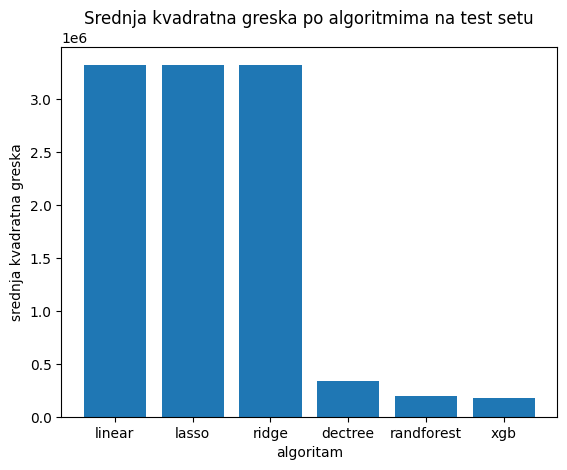

In [ ]:
plt.bar(names,mses)
plt.title("Srednja kvadratna greska po algoritmima na test setu")
plt.xlabel("algoritam")
plt.ylabel("srednja kvadratna greska")
plt.show()


####Cross-validation mehanizam

In [ ]:
kfold = StratifiedKFold(n_splits = 5,random_state=1,shuffle = True)
def cross_validate(name,model):
  neg_score = cross_val_score(model,X_train,y_train,cv=kfold,n_jobs=-1,scoring="neg_mean_squared_error")
  print("--------------------------------")
  print("model %s %f" %(name,-neg_score.mean()))
  names.append(name)
  return -neg_score.mean()

--------------------------------
model linear 3305585.351752
--------------------------------
model lasso 3308965.207768
--------------------------------
model ridge 3305532.367398
--------------------------------
model dectree 365157.206148
--------------------------------
model randforest 205465.272315
--------------------------------
model xgb 192719.340349


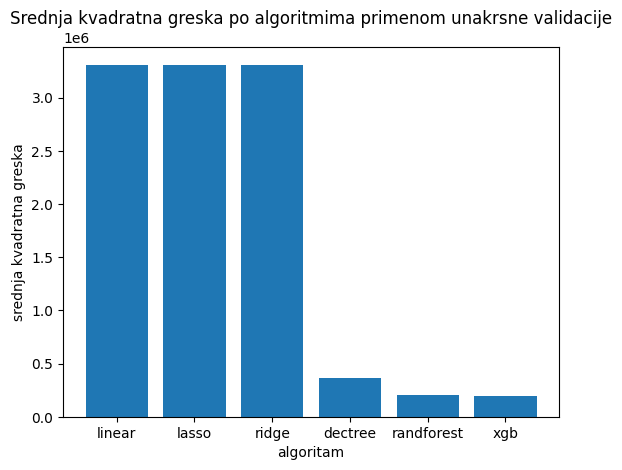

In [ ]:
cross_mses = []
names = []
for name,model in models:
  cross_mses.append(cross_validate(name,model))
plt.bar(names,cross_mses)
plt.title("Srednja kvadratna greska po algoritmima primenom unakrsne validacije")
plt.xlabel("algoritam")
plt.ylabel("srednja kvadratna greska")
plt.show()

####Odredjivanje hiperparametara


In [ ]:
def grid_search_cv(model,params):
  grid_search_model = GridSearchCV(estimator = model,param_grid = params, cv = 5,scoring = 'neg_mean_squared_error',n_jobs=-1)
  grid_search_model.fit(X_train, y_train)
  best_params = grid_search_model.best_params_
  best_score = -1*grid_search_model.best_score_
  best_estimator = grid_search_model.best_estimator_
  return best_estimator,best_params,best_score

In [ ]:
predictions_mse_score = []
predictions_mse_short_score = []
results_short = []

#####Decision Tree algoritam

In [ ]:
max_depth = np.arange(1,25,5)
min_samples_split = np.arange(2,10,2)
min_samples_leaf = [1,2,4]
params_dt={
    "splitter" : ["best","random"],
    "max_depth": max_depth,
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf
}
model,best_params_dt,best_score_dt = grid_search_cv(dt,params_dt)
features_importances = model.feature_importances_


In [ ]:
model.fit(X_train,y_train)
predictions = model.predict(X_test)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_score.append(met[5])

('r2_score: ', 0.9342502883791372, 'mae: ', 282.57992658295643, 'mse: ', 245469.59443146733, 'rmse: ', 495.44888175417987)


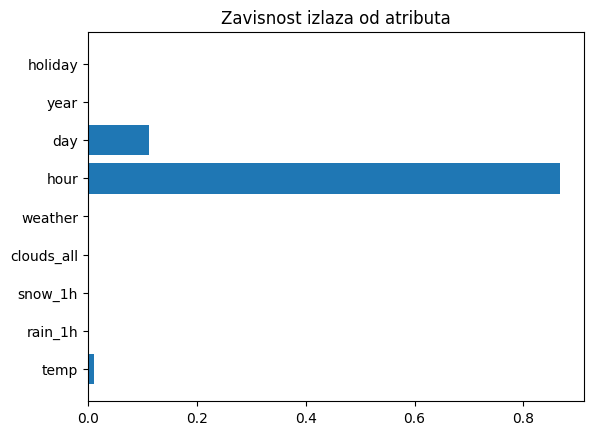

In [ ]:
y = np.arange(len(X_train.columns))
plt.barh(y=X_train.columns,width = features_importances)
plt.title("Zavisnost izlaza od atributa")
plt.show()

Na osnovu prikazanog grafikona moze se utvrditi da su najznacajniji atributi **hour**,**day**,**temp**,**year**, pa se za kreira novi model sa najboljim parametrima i trenira se nad nabrojanim atributima



In [ ]:
X_train_short = X_train[["hour","day","temp","year"]]
X_test_short = X_test[["hour","day","temp","year"]]
model = DecisionTreeRegressor(**best_params_dt)
cv_results= cross_val_score(model,X_train_short,y_train,cv = 5,scoring = "neg_mean_squared_error")
print("Decision tree nad najbitnijim atributima: %f (%f)"%(-1*cv_results.mean(),cv_results.std()))
model.fit(X_train_short,y_train)
results_short.append(-1*cv_results.mean())
predictions = model.predict(X_test_short)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_short_score.append(met[5])

Decision tree nad najbitnijim atributima: 258736.977473 (14412.354851)
('r2_score: ', 0.9359234136406563, 'mae: ', 281.827612944563, 'mse: ', 238454.5914874947, 'rmse: ', 488.3181252907726)


In [ ]:
data_predictions = {
    "klasicno treniranje":[mses[3],cross_mses[3]],
    "najbolji hiperparametri":[predictions_mse_score[0],best_score_dt],
    "redukcija dimenzionalnosti":[predictions_mse_short_score[0],results_short[0]]
  }
df_decisiontree = pd.DataFrame(data_predictions)
df_decisiontree.index=["test set","cross validacija"]
df_decisiontree

klasicno treniranje  najbolji hiperparametri  \
test set                337230.025444            245469.594431   
cross validacija        365157.206148            251926.197428   

                  redukcija dimenzionalnosti  
test set                       238454.591487  
cross validacija               258736.977473

Prilikom primene Decision Tree algoritma najmanja srednja kvadratna greska se postiza sa najbolje odredjenim hiperparametrima i redukcijom dimenzionalnosti podataka na svodjenjem na 4 karakteristike.

#####Random Forest algoritam

In [ ]:
params_rf= {
    'n_estimators': np.arange(10,25,10),
    'max_depth': np.arange(1,25,10),
    'min_samples_split': np.arange(2,10,2),
    'min_samples_leaf': [1, 2, 4]
}
best_model_rf,best_params_rf,best_score_rf = grid_search_cv(rf,params_rf)

In [ ]:
best_model_rf.fit(X_train,y_train)
predictions = best_model_rf.predict(X_test)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_score.append(met[5])

('r2_score: ', 0.9478141189575251, 'mae: ', 249.0622923808842, 'mse: ', 194355.8832365884, 'rmse: ', 440.8581214365778)


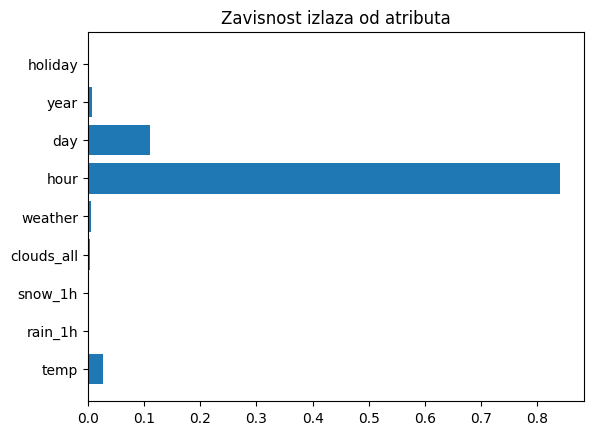

In [ ]:
features_importances_rf = best_model_rf.feature_importances_
y = np.arange(len(X_train.columns))
plt.barh(y=X_train.columns,width = features_importances_rf)
plt.title("Zavisnost izlaza od atributa")
plt.show()

In [ ]:
X_train_short = X_train[["hour","day","temp"]]
X_test_short = X_test[["hour","day","temp"]]
model = DecisionTreeRegressor(**best_params_dt)
cv_results= cross_val_score(model,X_train_short,y_train,cv = 5,scoring = "neg_mean_squared_error")
print("Random forest nad najbitnijim atributima: %f (%f)"%(-1*cv_results.mean(),cv_results.std()))
model.fit(X_train_short,y_train)
results_short.append(-1*cv_results.mean())
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_short_score.append(met[5])

Random forest nad najbitnijim atributima: 264799.571337 (17666.766382)
('r2_score: ', 0.9478141189575251, 'mae: ', 249.0622923808842, 'mse: ', 194355.8832365884, 'rmse: ', 440.8581214365778)


In [ ]:
data_predictions = {
    "klasicno treniranje":[mses[4],cross_mses[4]],
    "najbolji hiperparametri":[predictions_mse_score[1],best_score_rf],
    "redukcija dimenzionalnosti":[predictions_mse_short_score[1],results_short[1]]
  }
df_randomforest = pd.DataFrame(data_predictions)
df_randomforest.index=["test set","cross validacija"]
df_randomforest

klasicno treniranje  najbolji hiperparametri  \
test set                191554.695073            194355.883237   
cross validacija        205465.272315            213952.332603   

                  redukcija dimenzionalnosti  
test set                       194355.883237  
cross validacija               264799.571337

Primenom random forest algoritma postize se ista srednja kvadratna greska na test skupu sa i bez redukcije dimenzionalnosti podataka kod modela sa najboljim hipeparametrima, a kako je primenom unakrsne validacija manja greska je kada se ne vrsi redukcija dimenzionalnosti dataseta, najbolje resenje je primena modela sa najboljim hiperparametrima bez redukcije dimenzionalnosti podataka

#####Lasso regresija


In [ ]:
alpha = np.arange(0,1,0.1)
params_lasso= {
    'alpha':alpha

}
best_model_lasso,best_params_lasso,best_score_lasso = grid_search_cv(lasso,params_lasso)

Kod ovog algoritma moze se primeniti SelectFromModel za izdvajanje nenula koeficijenata, zbog osobine Lasso regresije.

In [ ]:
best_model_lasso.fit(X_train,y_train)
predictions = best_model_lasso.predict(X_test)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_score.append(met[5])
best_model_lasso.coef_

('r2_score: ', -4.101123025106862, 'mae: ', 1597.9055989426422, 'mse: ', 3317285.2217728887, 'rmse: ', 1821.3415994186507)


array([ 9.95867810e+02, -2.92261491e+03,  0.00000000e+00,  3.86790355e+02,
       -5.25220940e+01,  9.46900634e+01, -1.47735949e+02,  2.63343401e-01,
        1.41223161e+03])

Na osnovu prikazanih koeficijenata odlucuje se da je bolje izabrati 5 najznacajnijih nego nenula

In [ ]:
features_resizer= SelectFromModel(best_model_lasso,prefit=True,max_features = 5)
X_train_short = features_resizer.transform(X_train)

In [ ]:
X_test_short = features_resizer.transform(X_test)


In [ ]:
model = Lasso(**best_params_lasso)
cv_results= cross_val_score(model,X_train_short,y_train,cv = 5,scoring = "neg_mean_squared_error")
print("Lasso regresija nad najbitnijim atributima: %f (%f)"%(-1*cv_results.mean(),cv_results.std()))
model.fit(X_train_short,y_train)
results_short.append(-1*cv_results.mean())
predictions = model.predict(X_test_short)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_short_score.append(met[5])

Lasso regresija nad najbitnijim atributima: 3751983.369670 (58067.260081)
('r2_score: ', -17.90585199090799, 'mae: ', 1689.6510788505207, 'mse: ', 3755574.833138277, 'rmse: ', 1937.930554260982)


In [ ]:
predictions_mse_score

[245469.59443146733, 194355.8832365884, 3317285.2217728887]

In [ ]:
data_predictions = {
    "klasicno treniranje":[mses[1],cross_mses[1]],
    "najbolji hiperparametri":[predictions_mse_score[2],best_score_lasso],
    "redukcija dimenzionalnosti":[predictions_mse_short_score[2],results_short[2]]
  }
df_lasso = pd.DataFrame(data_predictions)
df_lasso.index=["test set","cross validacija"]
df_lasso

klasicno treniranje  najbolji hiperparametri  \
test set                 3.321090e+06             3.317285e+06   
cross validacija         3.308965e+06             3.305359e+06   

                  redukcija dimenzionalnosti  
test set                        3.755575e+06  
cross validacija                3.751983e+06

Kod Lasso regresije najbolji rezultati se postizu primenom modela sa najboljim hiperparametrima na trening setu cija je redukcija dimenzionalnosti izvrsena.

#####Ridge regresija

In [ ]:
params_ridge= {
    'alpha':np.arange(1,3,0.1)
}
best_model_ridge,best_params_ridge,best_score_ridge = grid_search_cv(ridge,params_ridge)

In [ ]:
best_model_ridge.fit(X_train,y_train)
predictions = best_model_ridge.predict(X_test)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_score.append(met[5])

('r2_score: ', -4.097171947908378, 'mae: ', 1597.8717091229028, 'mse: ', 3317296.424641154, 'rmse: ', 1821.3446748600754)


In [ ]:
dataset_tmp = X_train.copy()
dataset_tmp["traffic_value"]=y_train.values
dataset_tmp.head()

temp  rain_1h  snow_1h  clouds_all  weather  hour  day  year  \
43102  0.477804      0.0      0.0        0.68     0.25    14    1  2018   
180    0.550540      0.0      0.0        0.99     2.00     8    2  2012   
32911  0.498950      0.0      0.0        0.01     4.00     1    4  2017   
9793   0.288542      0.0      0.0        0.64     0.25     2    1  2013   
19199  0.486953      0.0      0.0        0.90     4.00    15    2  2015   

       holiday  traffic_value  
43102        1           5315  
180          1           6283  
32911        1            444  
9793         1            206  
19199        1           5691

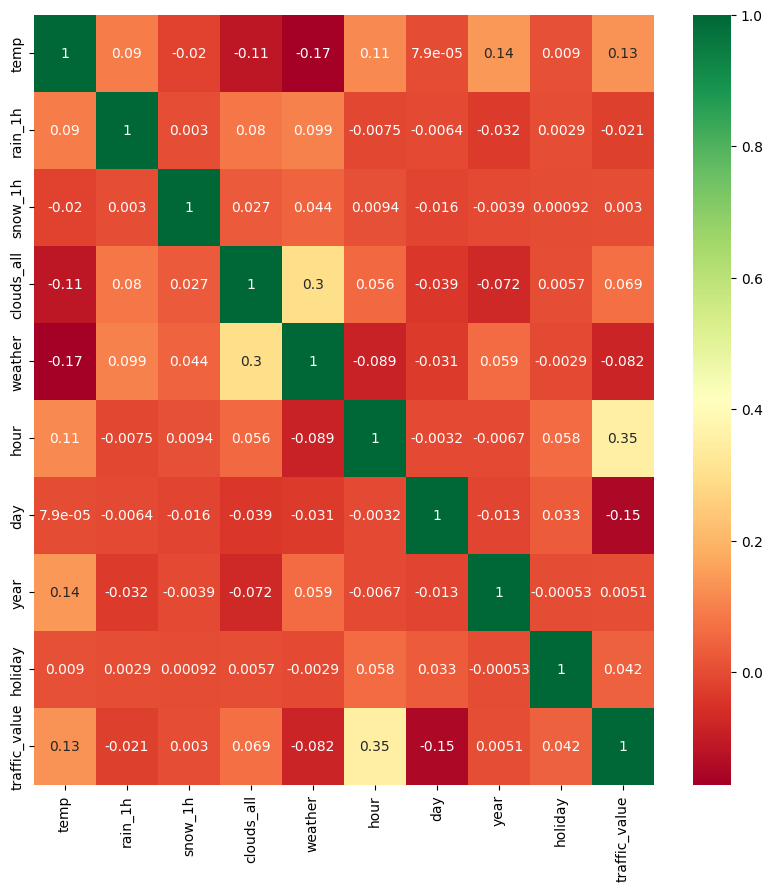

In [ ]:
corrmat = dataset_tmp.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g = sns.heatmap(dataset_tmp[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
target_corr = dataset_tmp[top_corr_features].corr()['traffic_value'].abs().sort_values(ascending=False)
print(target_corr)

traffic_value    1.000000
hour             0.352775
day              0.150571
temp             0.133214
weather          0.081713
clouds_all       0.069450
holiday          0.042164
rain_1h          0.021313
year             0.005147
snow_1h          0.002971
Name: traffic_value, dtype: float64


Na osnovu odredjenih korelacija atrubuti **hour**,**day**,**temp** najvise uticu na izlaz, pa se treniranje modela ponavlja nad tim atributima

In [ ]:
X_train_short = X_train[["hour","day","temp"]]
X_test_short = X_test[["hour","day","temp"]]

In [ ]:
model = Ridge(**best_params_ridge)
cv_results= cross_val_score(model,X_train_short,y_train,cv = 5,scoring = "neg_mean_squared_error")
print("Ridge regresija nad najbitnijim atributima: %f (%f)"%(-1*cv_results.mean(),cv_results.std()))
model.fit(X_train_short,y_train)
results_short.append(-1*cv_results.mean())
predictions = model.predict(X_test_short)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_short_score.append(met[5])

Ridge regresija nad najbitnijim atributima: 3336651.800602 (47606.551299)
('r2_score: ', -4.3758887478779, 'mae: ', 1608.6018199104276, 'mse: ', 3341500.650004969, 'rmse: ', 1827.9772017191485)


In [ ]:
data_predictions = {
    "klasicno treniranje":[mses[2],cross_mses[2]],
    "najbolji hiperparametri":[predictions_mse_score[3],best_score_ridge],
    "redukcija dimenzionalnosti":[predictions_mse_short_score[3],results_short[3]]
  }
df_ridge = pd.DataFrame(data_predictions)
df_ridge.index=["test set","cross validacija"]
df_ridge

klasicno treniranje  najbolji hiperparametri  \
test set                 3.317305e+06             3.317296e+06   
cross validacija         3.305532e+06             3.305567e+06   

                  redukcija dimenzionalnosti  
test set                        3.341501e+06  
cross validacija                3.336652e+06

Kod primene Ridge regresije najbolji rezultati se postizu prilikom primene modela sa najboljim hiperparametrima na test setu neredukovanih dimenzija.

#####XGBoost algoritam

In [ ]:
params_xgb= {
    'learning_rate':[0.01,0.1,0.3],
    'max_depth':[3,5,7],
    'subsample': [0.8, 0.9, 1.0]

}
best_model_xgb,best_params_xgb,best_score_xgb = grid_search_cv(xgb,params_xgb)

In [ ]:
best_model_xgb.fit(X_train,y_train)
predictions = best_model_xgb.predict(X_test)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_score.append(met[5])

('r2_score: ', 0.9537305421895477, 'mae: ', 245.29347514538537, 'mse: ', 174635.55856616568, 'rmse: ', 417.8941954205223)


Za ovoj algoritam iskoristicemo **PCA** metode za redukciju dimenzionalnosti. Na osnovu odabira atributa za prethodne algoritme pretpostavlja se da je 4 glavne komponente dovoljno.


In [ ]:
pca = PCA(n_components = 4)
pca.fit(X_train)
X_train_short = pca.transform(X_train)
X_test_short = pca.transform(X_test)

In [ ]:
model = XGBRegressor(**best_params_xgb)
cv_results= cross_val_score(model,X_train_short,y_train,cv = 5,scoring = "neg_mean_squared_error")
print("XGBoost nad najbitnijim atributima: %f (%f)"%(-1*cv_results.mean(),cv_results.std()))
model.fit(X_train_short,y_train)
results_short.append(-1*cv_results.mean())
predictions = model.predict(X_test_short)
met = eval_metrics(predictions,y_test)
print(met)
predictions_mse_short_score.append(met[5])

XGBoost nad najbitnijim atributima: 276334.810120 (16798.689071)
('r2_score: ', 0.9310904510279692, 'mae: ', 294.46144571773294, 'mse: ', 256625.17576811134, 'rmse: ', 506.58185495348266)


In [ ]:
data_predictions = {
    "klasicno treniranje":[mses[4],cross_mses[4]],
    "najbolji hiperparametri":[predictions_mse_score[4],best_score_xgb],
    "redukcija dimenzionalnosti":[predictions_mse_short_score[4],results_short[4]]
  }
df_xgb = pd.DataFrame(data_predictions)
df_xgb.index=["test set","cross validacija"]
df_xgb

klasicno treniranje  najbolji hiperparametri  \
test set                191554.695073            174635.558566   
cross validacija        205465.272315            185324.214910   

                  redukcija dimenzionalnosti  
test set                       256625.175768  
cross validacija               276334.810120

Najbolje rezultate dahe XGBoost kad se primenjuje sa najbolje odredjenim hiperparamtrima na setu kad nije izvrsena redukcija dimenzionalnosti.

###Rezultati

####Modeli sa najbolje odredjenim hiperparametrima

Dat je grafikon MSE kod algortama sa najbolje pronadjenim hiperparametrima na trening setu

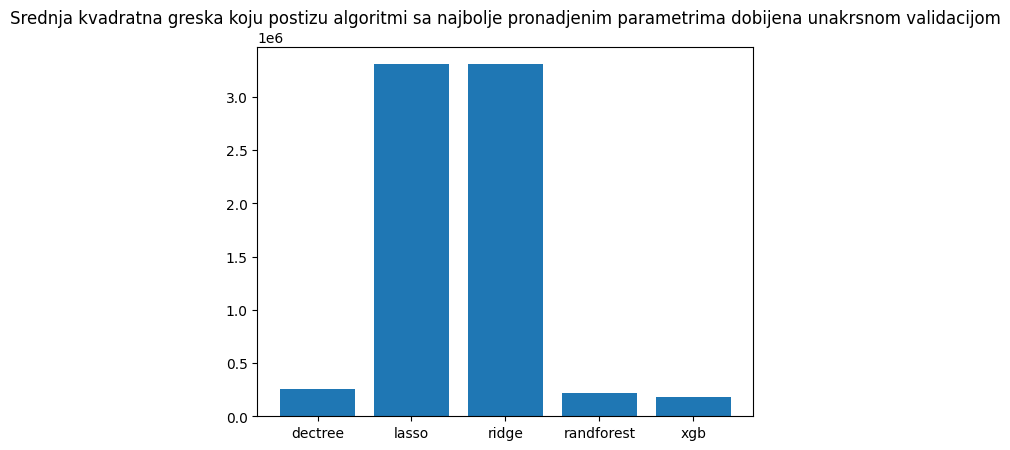

In [ ]:
y = [best_score_dt,best_score_lasso,best_score_ridge,best_score_rf,best_score_xgb]
plt.bar([ 'dectree','lasso', 'ridge','randforest','xgb'],y)
plt.title("Srednja kvadratna greska koju postizu algoritmi sa najbolje pronadjenim parametrima dobijena unakrsnom validacijom")
plt.show()


Dat je grafikon MSE dobijenih primenom algoritama sa najbolje pronadjenim hiperparametrima na test setu

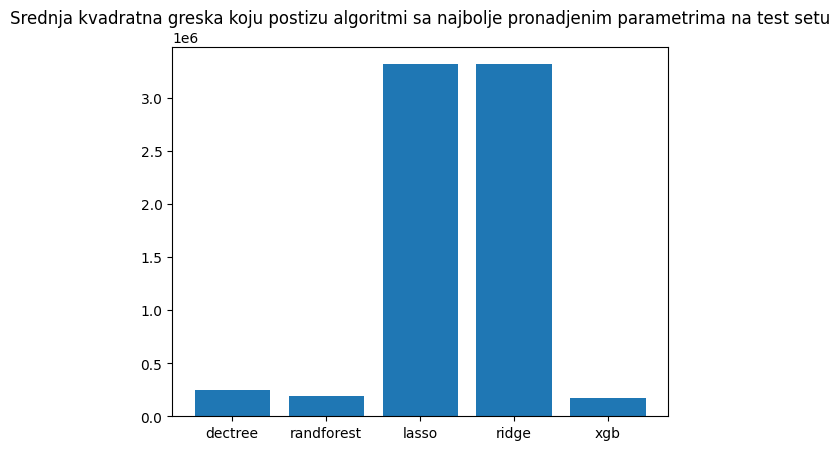

In [ ]:
plt.bar([ 'dectree','randforest','lasso', 'ridge','xgb'],predictions_mse_score)
plt.title("Srednja kvadratna greska koju postizu algoritmi sa najbolje pronadjenim parametrima na test setu")
plt.show()


####Modeli trenirani na podacima redukovanih dimenzija

Dat je grafikon MSE kod algortama sa najbolje pronadjenim hiperparametrima na najznacajnijim atributima trening seta

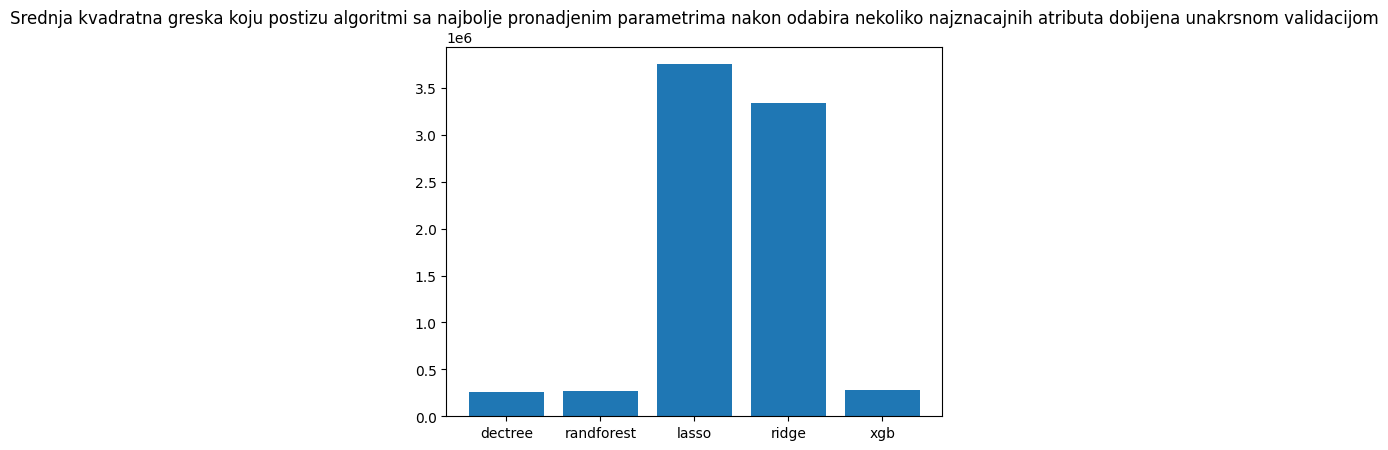

In [ ]:
plt.bar([ 'dectree','randforest','lasso', 'ridge','xgb'],results_short)
plt.title("Srednja kvadratna greska koju postizu algoritmi sa najbolje pronadjenim parametrima nakon odabira nekoliko najznacajnih atributa dobijena unakrsnom validacijom")
plt.show()

Dat je grafikon MSE dobijenih primenom algoritama sa najbolje pronadjenim hiperparametrima na datasetu redukovane dimenzionalnosti na test setu

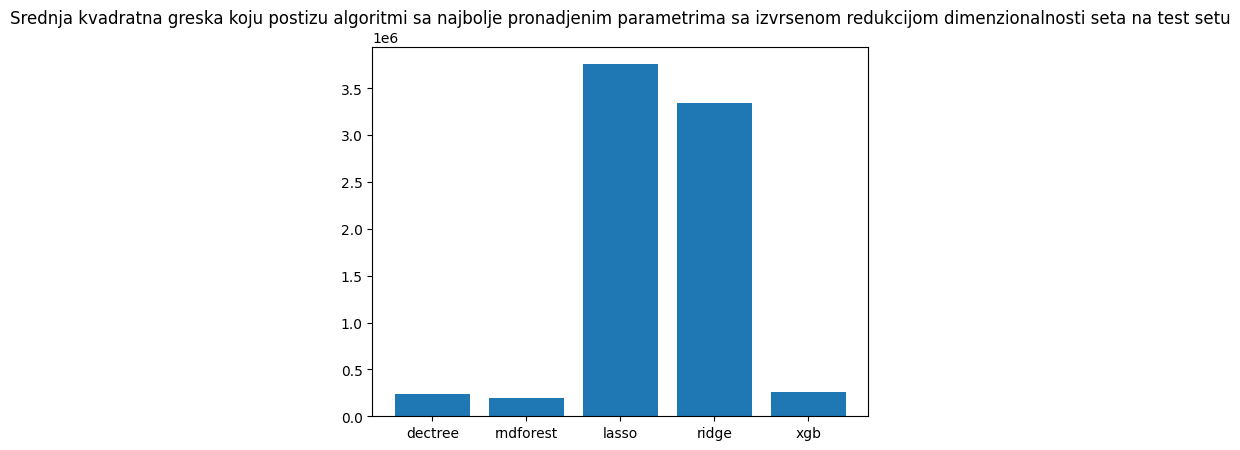

In [ ]:
plt.bar([ 'dectree','rndforest','lasso', 'ridge','xgb'],predictions_mse_short_score)
plt.title("Srednja kvadratna greska koju postizu algoritmi sa najbolje pronadjenim parametrima sa izvrsenom redukcijom dimenzionalnosti seta na test setu")
plt.show()

Kao zakljucak se moze izvesti da prilikom odredjivanja hiperparametara modela, najmanja greska se postize koriscenjem **XGBoost-a** nad datasetom, a nakon sto se izvrsi redukcija dimenzionalnosti dataseta **RandomForest**

### Ensamble learning
Vrsi se kombinacija ovih algoritama **Decision Tree**,**Random Forest** i **XGBoost**, s obzirom da daju najbolje rezultate. Prvo je izvrsena kombinacija svih model sa hiperparametrima koji daju najbolje rezultate.


In [ ]:
dectree = DecisionTreeRegressor(**best_params_dt)
randforest = RandomForestRegressor(**best_params_rf)
xgb = XGBRegressor(**best_params_xgb)

In [ ]:
dectree.fit(X_train, y_train)
randforest.fit(X_train,y_train)
xgb.fit(X_train, y_train)
pred_dectree = dectree.predict(X_test)
pred_randforest = randforest.predict(X_test)
pred_xgb = xgb.predict(X_test)

In [ ]:
met_xgb = eval_metrics(pred_xgb,y_test)
met_rand = eval_metrics(pred_randforest,y_test)
met_dt = eval_metrics(pred_dectree,y_test)
compare_df = pd.DataFrame({
    "decision tree":[met_dt[1],met_dt[3],met_dt[5],met_dt[7]],
    "random forest":[met_rand[1],met_rand[3],met_rand[5],met_rand[7]],
    "xgboost":[met_xgb[1],met_xgb[3],met_xgb[5],met_xgb[7]]
})
compare_df.index = ["r2_score","mae","mse","rmse"]
compare_df

decision tree  random forest        xgboost
r2_score       0.934251       0.946393       0.953731
mae          282.585462     251.805339     245.293475
mse       245470.843488  199816.814877  174635.558566
rmse         495.450142     447.008741     417.894195

In [ ]:
voting_reg_1 = VotingRegressor(estimators=[("dectree",dectree),("randomforest",randforest),("xgb",xgb)])
voting_reg_1.fit(X_train,y_train)

VotingRegressor(estimators=[('dectree',
                             DecisionTreeRegressor(max_depth=11,
                                                   min_samples_leaf=4)),
                            ('randomforest',
                             RandomForestRegressor(max_depth=21,
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=20)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          earl...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.3, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
predictions_1 = voting_reg_1.predict(X_test)
met = eval_metrics(predictions_1,y_test)
compare_df["dectree&randforest&xgb"] = [met[1],met[3],met[5],met[7]]
compare_df

decision tree  random forest        xgboost  dectree&randforest&xgb
r2_score       0.934251       0.946393       0.953731                0.950506
mae          282.585462     251.805339     245.293475              243.706963
mse       245470.843488  199816.814877  174635.558566           184368.679219
rmse         495.450142     447.008741     417.894195              429.381741

Kombinacijom ne dobija se poboljsanje,pa ce se isprobati kombinacije svaka dva od tri navedena algoritma


In [ ]:
voting_reg_2 = VotingRegressor(estimators=[("dectree",dectree),("randomforest",randforest)])
voting_reg_2.fit(X_train,y_train)

VotingRegressor(estimators=[('dectree',
                             DecisionTreeRegressor(max_depth=11,
                                                   min_samples_leaf=4)),
                            ('randomforest',
                             RandomForestRegressor(max_depth=21,
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=20))])

In [ ]:
predictions_2 = voting_reg_2.predict(X_test)
met = eval_metrics(predictions_2,y_test)
compare_df["dectree&randforest"] = [met[1],met[3],met[5],met[7]]
compare_df

decision tree  random forest        xgboost  dectree&randforest&xgb  \
r2_score       0.934251       0.946393       0.953731                0.950506   
mae          282.585462     251.805339     245.293475              243.706963   
mse       245470.843488  199816.814877  174635.558566           184368.679219   
rmse         495.450142     447.008741     417.894195              429.381741   

          dectree&randforest  
r2_score            0.944309  
mae               256.940246  
mse            206906.098567  
rmse              454.869320

In [ ]:
voting_reg_3 = VotingRegressor(estimators=[("dectree",dectree),("xgb",xgb)])
voting_reg_3.fit(X_train,y_train)

VotingRegressor(estimators=[('dectree',
                             DecisionTreeRegressor(max_depth=11,
                                                   min_samples_leaf=4)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.3, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
predictions_3 = voting_reg_3.predict(X_test)
met = eval_metrics(predictions_3,y_test)
compare_df["dectree&xgb"] = [met[1],met[3],met[5],met[7]]
compare_df

decision tree  random forest        xgboost  dectree&randforest&xgb  \
r2_score       0.934251       0.946393       0.953731                0.950506   
mae          282.585462     251.805339     245.293475              243.706963   
mse       245470.843488  199816.814877  174635.558566           184368.679219   
rmse         495.450142     447.008741     417.894195              429.381741   

          dectree&randforest    dectree&xgb  
r2_score            0.944309       0.948989  
mae               256.940246     250.055562  
mse            206906.098567  190471.246787  
rmse              454.869320     436.430117

In [ ]:
voting_reg_4 = VotingRegressor(estimators=[("randforest",randforest),("xgb",xgb)])
voting_reg_4.fit(X_train,y_train)

VotingRegressor(estimators=[('randforest',
                             RandomForestRegressor(max_depth=21,
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=20)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feat...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.3, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
predictions_4 = voting_reg_4.predict(X_test)
met = eval_metrics(predictions_4,y_test)
compare_df["randforest&xgb"] = [met[1],met[3],met[5],met[7]]
compare_df

decision tree  random forest        xgboost  dectree&randforest&xgb  \
r2_score       0.934251       0.946393       0.953731                0.950506   
mae          282.585462     251.805339     245.293475              243.706963   
mse       245470.843488  199816.814877  174635.558566           184368.679219   
rmse         495.450142     447.008741     417.894195              429.381741   

          dectree&randforest    dectree&xgb  randforest&xgb  
r2_score            0.944309       0.948989        0.953825  
mae               256.940246     250.055562      237.922830  
mse            206906.098567  190471.246787   172494.820364  
rmse              454.869320     436.430117      415.324958

Na osnovu prikazane tabele gde su navedene metrike modela i njihovih kombinacija biramo MSE kao meru uporedjivanja, dobija se da najbolje rezultate daje kombinacija **Random Forest** i **XGBoost** .

# **ALGORITMI - RAZLICITE VARIJANTE**

Primenjuju se kombinacija algoritama **Random Forest** i **XGBoost**, kako se pokazala kao najbolja, na razlicitim varijantama dataseta, kako bi se pronaslo sto bolje resenje problema.

In [ ]:
r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []

In [ ]:
randforest = RandomForestRegressor(**best_params_rf)
xgb = XGBRegressor(**best_params_xgb)
voting_reg = VotingRegressor(estimators=[("randforest",randforest),("xgb",xgb)])
voting_reg.fit(X_train2,y_train)

VotingRegressor(estimators=[('randforest',
                             RandomForestRegressor(max_depth=21,
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=20)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feat...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.3, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
predictions = voting_reg.predict(X_test2)
met = eval_metrics(predictions,y_test)
r2_scores.append(met[1])
mae_scores.append(met[3])
mse_scores.append(met[5])
rmse_scores.append(met[7])

In [ ]:
X_train3 = X_train2.copy()
X_train4 = X_train2.copy()
X_train5 = X_train2.copy()
X_test3 = X_test2.copy()
X_test4 = X_test2.copy()
X_test5 = X_test2.copy()

Prva varijanta izmenjenog dataseta je kada se koristi one-hot metoda za kodiranje kategorickih vrednosti polaznog atributa holiday

In [ ]:
X_train3.drop(['holiday', 'weekend'], axis = 1, inplace = True)
X_test3.drop(['holiday', 'weekend'], axis = 1, inplace = True)
X_train3

temp  rain_1h  snow_1h  clouds_all  weather  hour  day  year  \
43102  0.477804      0.0      0.0        0.68     0.25    14    1  2018   
180    0.550540      0.0      0.0        0.99     2.00     8    2  2012   
32911  0.498950      0.0      0.0        0.01     4.00     1    4  2017   
9793   0.288542      0.0      0.0        0.64     0.25     2    1  2013   
19199  0.486953      0.0      0.0        0.90     4.00    15    2  2015   
...         ...      ...      ...         ...      ...   ...  ...   ...   
11284  0.080984      0.0      0.0        0.40     0.00     7    1  2014   
44743  0.728104      0.0      0.0        0.01     1.00     0    3  2018   
38169  0.662717      0.0      0.0        0.01     1.00    23    3  2017   
860    0.387672      0.0      0.0        0.20     0.75     7    5  2012   
15805  0.839082      0.0      0.0        0.01     1.00    17    2  2014   

       holiday_christmas day  holiday_columbus day  holiday_independence day  \
43102                      0                     0                         0   
180                        0                     0                         0   
32911                      0                     0                         0   
9793                       0                     0                         0   
19199                      0                     0                         0   
...                      ...                   ...                       ...   
11284                      0                     0                         0   
44743                      0                     0                         0   
38169                      0                     0                         0   
860                        0                     0                         0   
15805                      0                     0                         0   

       holiday_labor day  holiday_martin luther king jr day  \
43102                  0                                  0   
180                    0                                  0   
32911                  0                                  0   
9793                   0                                  0   
19199                  0                                  0   
...                  ...                                ...   
11284                  0                                  0   
44743                  0                                  0   
38169                  0                                  0   
860                    0                                  0   
15805                  0                                  0   

       holiday_memorial day  holiday_new years day  holiday_none  \
43102                     0                      0             1   
180                       0                      0             1   
32911                     0                      0             1   
9793                      0                      0             1   
19199                     0                      0             1   
...                     ...                    ...           ...   
11284                     0                      0             1   
44743                     0                      0             1   
38169                     0                      0             1   
860                       0                      0             1   
15805                     0                      0             1   

       holiday_state fair  holiday_thanksgiving day  holiday_veterans day  \
43102                   0                         0                     0   
180                     0                         0                     0   
32911                   0                         0                     0   
9793                    0                         0                     0   
19199                   0                         0                     0   
...                   ...                       ...                   ...   
11284                   0           

In [ ]:
voting_reg = VotingRegressor(estimators=[("randforest",randforest),("xgb",xgb)])
voting_reg.fit(X_train3,y_train)
predictions = voting_reg.predict(X_test3)
met = eval_metrics(predictions,y_test)
r2_scores.append(met[1])
mae_scores.append(met[3])
mse_scores.append(met[5])
rmse_scores.append(met[7])

Naredna varijanta je kada se polazni atributi **holiday** i **date_time** zamenjuju, tako da atribut **holiday** ima vrednosti 0 i 1, gde 1 oznacava da je praznik u pitanju, a 0 suprotno i uvodi se nova kolona **weekend** koja takodje ima vrednosti 0 i 1, gde 1 oznacava da je vikend u pitanju, a 0 suprotno.

In [ ]:
X_train4.drop(['holiday_christmas day', 'holiday_columbus day', 'holiday_martin luther king jr day', 'holiday_memorial day', 'holiday_independence day', 'holiday_labor day', 'holiday_new years day', 'holiday_none', 'holiday_state fair', 'holiday_thanksgiving day', 'holiday_veterans day', 'holiday_washingtons birthday', 'day'], axis = 1, inplace = True)
X_test4.drop(['holiday_christmas day', 'holiday_columbus day', 'holiday_martin luther king jr day', 'holiday_memorial day', 'holiday_independence day', 'holiday_labor day', 'holiday_new years day', 'holiday_none', 'holiday_state fair', 'holiday_thanksgiving day', 'holiday_veterans day', 'holiday_washingtons birthday', 'day'], axis = 1, inplace = True)
X_train4

temp  rain_1h  snow_1h  clouds_all  weather  hour  year  holiday  \
43102  0.477804      0.0      0.0        0.68     0.25    14  2018        1   
180    0.550540      0.0      0.0        0.99     2.00     8  2012        1   
32911  0.498950      0.0      0.0        0.01     4.00     1  2017        1   
9793   0.288542      0.0      0.0        0.64     0.25     2  2013        1   
19199  0.486953      0.0      0.0        0.90     4.00    15  2015        1   
...         ...      ...      ...         ...      ...   ...   ...      ...   
11284  0.080984      0.0      0.0        0.40     0.00     7  2014        1   
44743  0.728104      0.0      0.0        0.01     1.00     0  2018        1   
38169  0.662717      0.0      0.0        0.01     1.00    23  2017        1   
860    0.387672      0.0      0.0        0.20     0.75     7  2012        1   
15805  0.839082      0.0      0.0        0.01     1.00    17  2014        1   

       weekend  
43102        0  
180          0  
32911        0  
9793         0  
19199        0  
...        ...  
11284        0  
44743        0  
38169        0  
860          1  
15805        0  

[38554 rows x 9 columns]

In [ ]:
voting_reg = VotingRegressor(estimators=[("randforest",randforest),("xgb",xgb)])
voting_reg.fit(X_train4,y_train)
predictions = voting_reg.predict(X_test4)
met = eval_metrics(predictions,y_test)
r2_scores.append(met[1])
mae_scores.append(met[3])
mse_scores.append(met[5])
rmse_scores.append(met[7])

Poslednja varijanta dataseta transformise sve numericke podatke u preprocesiranom datasetu, tako da vrednosti atributa prate normalnu raspodelu

In [ ]:
X_train5.drop(['holiday_christmas day', 'holiday_columbus day', 'holiday_martin luther king jr day', 'holiday_memorial day', 'holiday_independence day', 'holiday_labor day', 'holiday_new years day', 'holiday_none', 'holiday_state fair', 'holiday_thanksgiving day', 'holiday_veterans day', 'holiday_washingtons birthday', 'weekend'], axis = 1, inplace = True)
X_test5.drop(['holiday_christmas day', 'holiday_columbus day', 'holiday_martin luther king jr day', 'holiday_memorial day', 'holiday_independence day', 'holiday_labor day', 'holiday_new years day', 'holiday_none', 'holiday_state fair', 'holiday_thanksgiving day', 'holiday_veterans day', 'holiday_washingtons birthday', 'weekend'], axis = 1, inplace = True)
X_train5

temp  rain_1h  snow_1h  clouds_all  weather  hour  day  year  \
43102  0.477804      0.0      0.0        0.68     0.25    14    1  2018   
180    0.550540      0.0      0.0        0.99     2.00     8    2  2012   
32911  0.498950      0.0      0.0        0.01     4.00     1    4  2017   
9793   0.288542      0.0      0.0        0.64     0.25     2    1  2013   
19199  0.486953      0.0      0.0        0.90     4.00    15    2  2015   
...         ...      ...      ...         ...      ...   ...  ...   ...   
11284  0.080984      0.0      0.0        0.40     0.00     7    1  2014   
44743  0.728104      0.0      0.0        0.01     1.00     0    3  2018   
38169  0.662717      0.0      0.0        0.01     1.00    23    3  2017   
860    0.387672      0.0      0.0        0.20     0.75     7    5  2012   
15805  0.839082      0.0      0.0        0.01     1.00    17    2  2014   

       holiday  
43102        1  
180          1  
32911        1  
9793         1  
19199        1  
...        ...  
11284        1  
44743        1  
38169        1  
860          1  
15805        1  

[38554 rows x 9 columns]

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
X_train5 = pd.DataFrame(qt.fit_transform(X_train5), columns=X_train5.columns)
X_test5 = pd.DataFrame(qt.fit_transform(X_test5), columns=X_train5.columns)
X_test5

temp   rain_1h   snow_1h  clouds_all   weather      hour       day  \
0    -1.300216 -5.199338 -5.199338   -0.180377  1.204935 -0.352151  0.360172   
1    -1.703666 -5.199338 -5.199338   -0.008782  2.043115 -0.593940 -0.373591   
2    -0.744529 -5.199338 -5.199338   -0.444534 -0.116941  0.599937 -0.373591   
3    -0.051460 -5.199338 -5.199338    0.869846  0.645631 -0.593940 -0.373591   
4    -1.083201 -5.199338 -5.199338    0.869846 -0.763030  0.266584  0.798769   
...        ...       ...       ...         ...       ...       ...       ...   
9634 -0.239380 -5.199338 -5.199338    0.869846  0.326900 -0.243255  5.199338   
9635 -0.486480 -5.199338 -5.199338    0.869846  0.326900  1.513589  0.798769   
9636  0.694311 -5.199338 -5.199338   -0.941700 -0.116941 -5.199338  5.199338   
9637 -0.670557 -5.199338 -5.199338    0.869846 -0.763030 -0.035135  0.798769   
9638  0.548644 -5.199338 -5.199338   -0.941700 -0.116941 -0.723343  0.360172   

          year   holiday  
0     5.199338  5.199338  
1    -0.579039  5.199338  
2     0.605955  5.199338  
3    -0.321611  5.199338  
4     0.605955  5.199338  
...        ...       ...  
9634 -1.064091  5.199338  
9635 -1.064091  5.199338  
9636  0.605955  5.199338  
9637  0.605955  5.199338  
9638 -0.321611  5.199338  

[9639 rows x 9 columns]

In [ ]:
voting_reg = VotingRegressor(estimators=[("randforest",randforest),("xgb",xgb)])
voting_reg.fit(X_train5,y_train)
predictions = voting_reg.predict(X_test5)
met = eval_metrics(predictions,y_test)
r2_scores.append(met[1])
mae_scores.append(met[3])
mse_scores.append(met[5])
rmse_scores.append(met[7])

In [ ]:
data= {
    "r2":r2_scores,
    "mae":mae_scores,
    "mse":mse_scores,
    "rmse":rmse_scores
}
df = pd.DataFrame(data, index=['1.varijanta',
                               '2.varijanta',
                               '3.varijanta',
                               '4.varijanta'])
df

r2         mae            mse        rmse
1.varijanta  0.953475  237.807464  174168.846006  417.335412
2.varijanta  0.953667  237.703973  173223.959862  416.201826
3.varijanta  0.940302  290.011057  220598.596654  469.679249
4.varijanta  0.934552  310.748478  236350.583631  486.159011

Nakon testiranja četiri različite varijante zaključili smo da su prve dve veoma slične po performansama dok su druge dve značajno gore. Iz tog razloga smo testirali i vreme izvršenja algoritama za prvu i drugu varijantu.

## **ANAIZA VREMENA IZVRSENJA**

In [ ]:
import time
seed = 43
dt = DecisionTreeRegressor(random_state = seed)
rf = RandomForestRegressor(random_state = seed, n_jobs = -1)
xgb = XGBRegressor (random_state = seed, n_jobs = -1)
models_vreme = [('dectree',dt),('randforest',rf),('xgb',xgb)]

In [ ]:
def train_mse_vreme(name,model):
  train_model = model.fit(X_train,y_train)
  predicted = train_model.predict(X_test)
  names.append(name)
  return mean_squared_error(y_test, predicted)

In [ ]:
def train_mse_vreme2(name,model):
  train_model = model.fit(X_train2,y_train)
  predicted = train_model.predict(X_test2)
  names.append(name)
  return mean_squared_error(y_test, predicted)

In [ ]:
names_vreme = []
mses_vreme = []

print("Varijanta prva\n")
t0 = time.perf_counter()
for name,model in models_vreme:
  t1 = time.perf_counter()
  mses_vreme.append(train_mse_vreme(name,model))
  t2 = time.perf_counter()
  print(name + ' vreme:',t2-t1)
t3 = time.perf_counter()
print('Ukupno prva varijanta:',t3-t0)

print("\n Varijanta druga\n")
t0 = time.perf_counter()
for name,model in models_vreme:
  t1 = time.perf_counter()
  mses_vreme.append(train_mse_vreme2(name,model))
  t2 = time.perf_counter()
  print(name + ' vreme:',t2-t1)
t3 = time.perf_counter()
print('Ukupno druga varijanta:',t3-t0)


Varijanta prva

dectree vreme: 0.2050977930011868
randforest vreme: 11.861293038997246
xgb vreme: 0.40993177499694866
Ukupno prva varijanta: 12.478902785998798

 Varijanta druga

dectree vreme: 0.23109916600151337
randforest vreme: 11.335700597999676
xgb vreme: 2.049507943000208
Ukupno druga varijanta: 13.624736582998594


Kada se model trenira i testira nad prvom varijantom podataka manje vremena je neophodno nego kada se trenira i testira nad drugom varijantom. Treba uzeti u obzir da bi razlika bila veća da se meri i vreme određivanja hiperparametara. S toga možemo zaključiti da najbolje rezultate postiže kombinacija **xgb** i **randforest** nad prvom varijantom podataka.